**Upload Kaggle API Token**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaichanoka","key":"70fe953a9a023799a41a3a3cb63a4a14"}'}

**Setting Up**

In [ ]:
import os
import zipfile

os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

**Download Dataset**

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors


**Unzip loaded dataset**

In [ ]:
with zipfile.ZipFile("covid19-radiography-database.zip", 'r') as zip_ref:
    zip_ref.extractall("covid19-radiography-database")

**Check data inside and visualization**

Count number of each class sample

In [ ]:
import os
from glob import glob

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL_Pneumonia": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

for label, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    image_count = len(glob(os.path.join(image_folder, "*.png")))
    print(f"{label:15s}: {image_count} images")

COVID          : 3616 images
NORMAL         : 10192 images
VIRAL_Pneumonia: 1345 images
LUNG_OPACITY   : 6012 images


Plot into bar graph

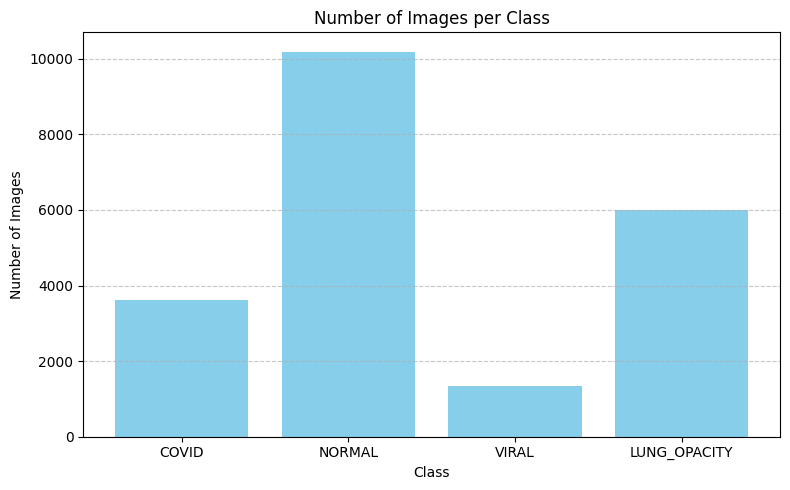

In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

class_counts = {}

for label, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    count = len(glob(os.path.join(image_folder, "*.png")))
    class_counts[label] = count

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Peek at some of the pictures**

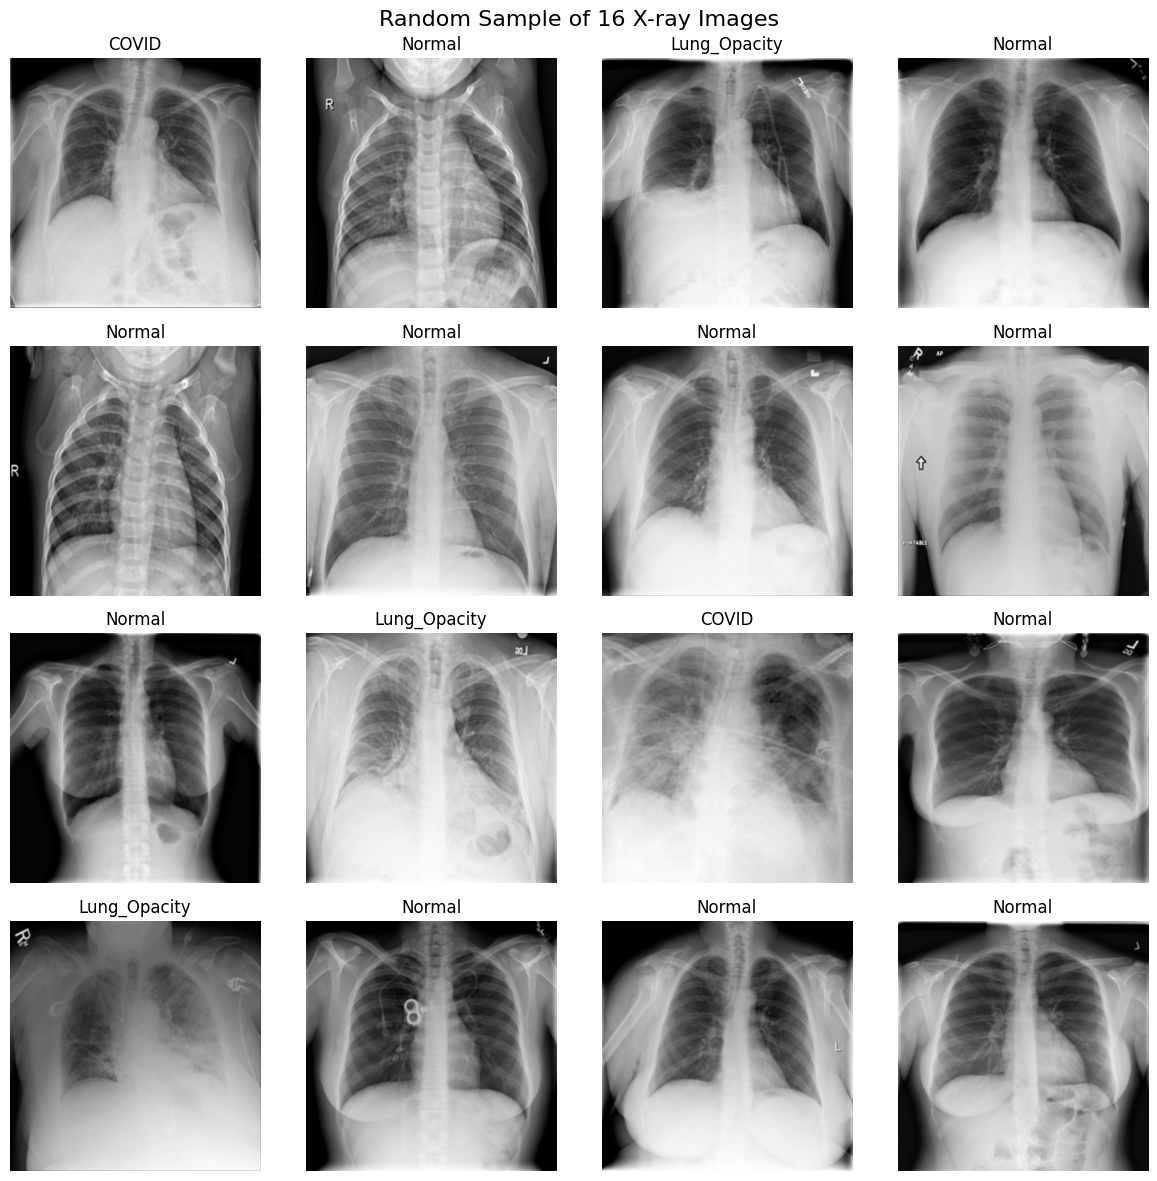

In [ ]:
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

all_image_paths = []
for folder in class_folders.values():
    image_folder = os.path.join(data_path, folder, "images")
    all_image_paths.extend(glob(os.path.join(image_folder, "*.png")))

sample_images = random.sample(all_image_paths, 16)

plt.figure(figsize=(12, 12))
for i, img_path in enumerate(sample_images):
    try:
        img = mpimg.imread(img_path)
        plt.subplot(4, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(os.path.dirname(os.path.dirname(img_path))))  # แสดงชื่อ class
    except Exception as e:
        print(f"❌ Error loading {img_path}: {e}")
plt.suptitle("Random Sample of 16 X-ray Images", fontsize=16)
plt.tight_layout()
plt.show()

Clear the blured images out

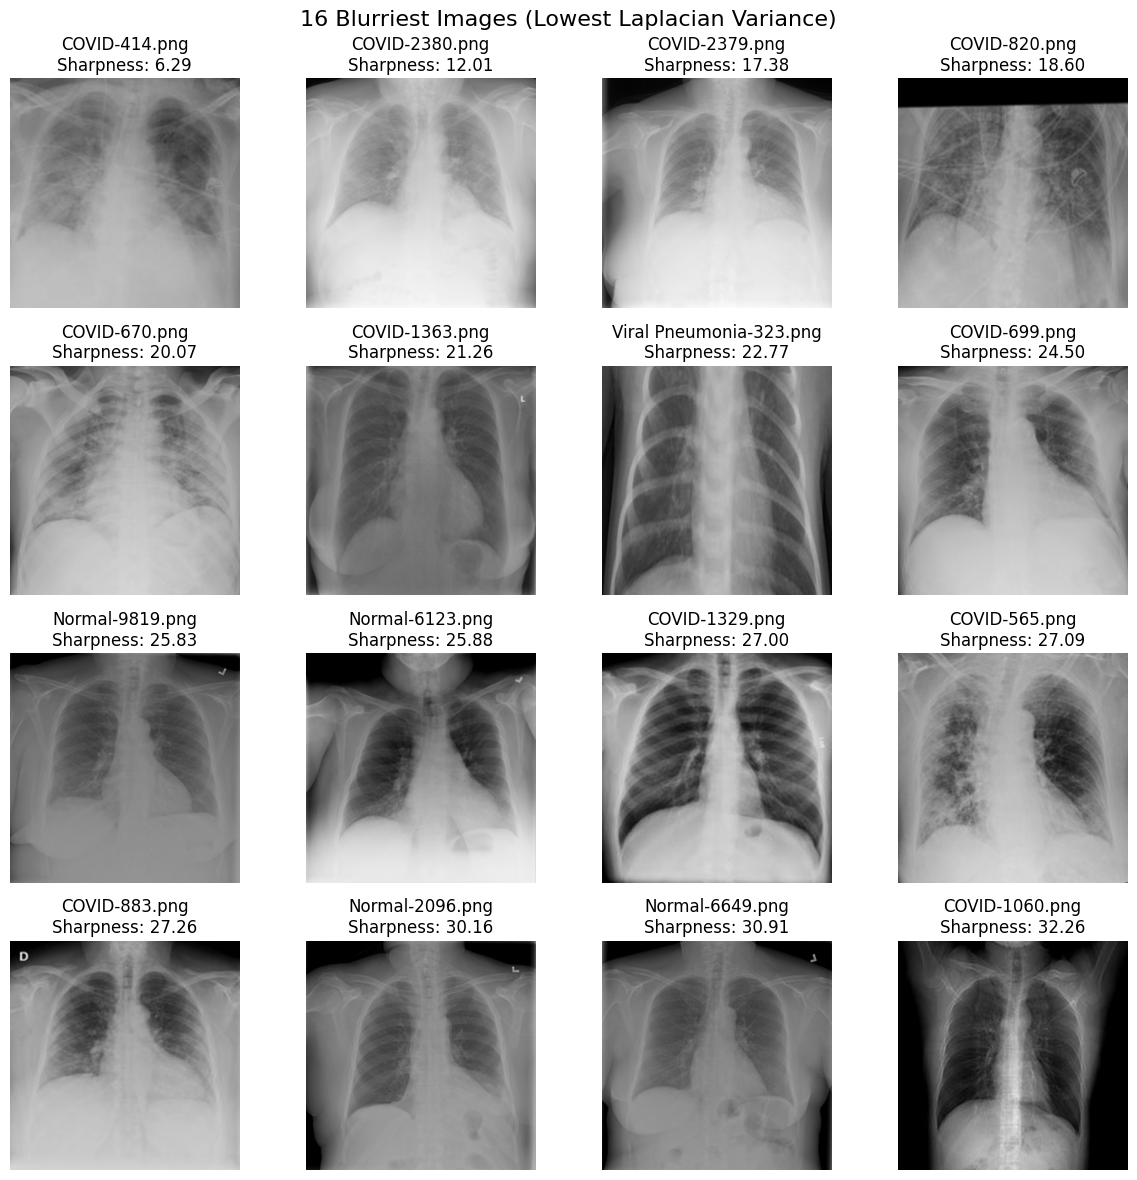

In [ ]:
import os
import cv2
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

all_image_paths = []
for folder in class_folders.values():
    image_folder = os.path.join(data_path, folder, "images")
    all_image_paths.extend(glob(os.path.join(image_folder, "*.png")))

sampled_paths = random.sample(all_image_paths, min(500, len(all_image_paths)))

image_sharpness = []
for path in sampled_paths:
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        sharpness = variance_of_laplacian(img)
        image_sharpness.append((path, sharpness))
    except:
        pass

blurriest_images = sorted(image_sharpness, key=lambda x: x[1])[:16]

plt.figure(figsize=(12, 12))
for i, (path, sharpness) in enumerate(blurriest_images):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{os.path.basename(path)}\nSharpness: {sharpness:.2f}")
plt.suptitle("16 Blurriest Images (Lowest Laplacian Variance)", fontsize=16)
plt.tight_layout()
plt.show()

Delete all images with the sharpness below 31

In [ ]:
import os
import cv2
from glob import glob

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

sharpness_threshold = 31

deleted_count = 0

for class_name, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    image_paths = glob(os.path.join(image_folder, "*.png"))

    for path in image_paths:
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            sharpness = variance_of_laplacian(img)
            if sharpness < sharpness_threshold:
                os.remove(path)
                deleted_count += 1
                print(f"🗑️ Deleted: {path} (Sharpness: {sharpness:.2f})")
        except Exception as e:
            print(f"❌ Error processing {path}: {e}")

print(f"\n✅ Completed. Total deleted: {deleted_count} images")

🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2379.png (Sharpness: 17.38)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2181.png (Sharpness: 26.32)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1462.png (Sharpness: 20.93)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2033.png (Sharpness: 15.73)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2184.png (Sharpness: 27.99)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-46.png (Sharpness: 21.13)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-688.png (Sharpness: 16.43)
🗑️ Deleted: /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-249.png (Sharpness: 18.

**Balancing the data**

In [ ]:
import os
from glob import glob

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL_Pneumonia": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

for label, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    image_count = len(glob(os.path.join(image_folder, "*.png")))
    print(f"{label:15s}: {image_count} images")

COVID          : 3199 images
NORMAL         : 10126 images
VIRAL_Pneumonia: 1294 images
LUNG_OPACITY   : 5995 images


In [ ]:
import os
import random
from glob import glob

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

max_images = 1200

total_deleted = 0

for label, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    image_paths = glob(os.path.join(image_folder, "*.png"))

    if len(image_paths) > max_images:
        to_delete = len(image_paths) - max_images
        delete_paths = random.sample(image_paths, to_delete)

        for path in delete_paths:
            try:
                os.remove(path)
                total_deleted += 1
                print(f"🗑️ Deleted from {label}: {os.path.basename(path)}")
            except Exception as e:
                print(f"❌ Error deleting {path}: {e}")
    else:
        print(f"✅ {label}: {len(image_paths)} images (no need to delete)")

print(f"\n🎯 Done! Total images deleted: {total_deleted}")

Streaming output truncated to the last 5000 lines.
🗑️ Deleted from NORMAL: Normal-7446.png
🗑️ Deleted from NORMAL: Normal-2675.png
🗑️ Deleted from NORMAL: Normal-5206.png
🗑️ Deleted from NORMAL: Normal-9769.png
🗑️ Deleted from NORMAL: Normal-8902.png
🗑️ Deleted from NORMAL: Normal-936.png
🗑️ Deleted from NORMAL: Normal-9838.png
🗑️ Deleted from NORMAL: Normal-6119.png
🗑️ Deleted from NORMAL: Normal-9791.png
🗑️ Deleted from NORMAL: Normal-9236.png
🗑️ Deleted from NORMAL: Normal-5908.png
🗑️ Deleted from NORMAL: Normal-7979.png
🗑️ Deleted from NORMAL: Normal-7702.png
🗑️ Deleted from NORMAL: Normal-3342.png
🗑️ Deleted from NORMAL: Normal-3860.png
🗑️ Deleted from NORMAL: Normal-1080.png
🗑️ Deleted from NORMAL: Normal-7946.png
🗑️ Deleted from NORMAL: Normal-7565.png
🗑️ Deleted from NORMAL: Normal-6808.png
🗑️ Deleted from NORMAL: Normal-5385.png
🗑️ Deleted from NORMAL: Normal-7381.png
🗑️ Deleted from NORMAL: Normal-2610.png
🗑️ Deleted from NORMAL: Normal-8821.png
🗑️ Deleted from NORMAL: Normal

In [ ]:
import os
from glob import glob

data_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL_Pneumonia": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

for label, folder in class_folders.items():
    image_folder = os.path.join(data_path, folder, "images")
    image_count = len(glob(os.path.join(image_folder, "*.png")))
    print(f"{label:15s}: {image_count} images")

COVID          : 1200 images
NORMAL         : 1200 images
VIRAL_Pneumonia: 1200 images
LUNG_OPACITY   : 1200 images


**Make new folder for the dataset**

In [ ]:
import os

base_dir = "swindataset"
splits = ["train", "test"]
classes = ["COVID", "NORMAL", "VIRAL_PNEUMONIA", "LUNG_OPACITY"]

for split in splits:
    for class_name in classes:
        dir_path = os.path.join(base_dir, split, class_name)
        os.makedirs(dir_path, exist_ok=True)

**Split and move data into created folder**

In [ ]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

source_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset"

target_path = "/content/swindataset"

class_folders = {
    "COVID": "COVID",
    "NORMAL": "Normal",
    "VIRAL_PNEUMONIA": "Viral Pneumonia",
    "LUNG_OPACITY": "Lung_Opacity"
}

train_ratio = 0.7

for class_name, folder_name in class_folders.items():
    src_folder = os.path.join(source_path, folder_name, "images")
    all_images = glob(os.path.join(src_folder, "*.png"))
    random.shuffle(all_images)

    train_count = int(len(all_images) * train_ratio)
    train_images = all_images[:train_count]
    test_images = all_images[train_count:]

    print(f"📁 Copying {len(train_images)} train images for {class_name}...")
    for img_path in tqdm(train_images):
        dst = os.path.join(target_path, "train", class_name, os.path.basename(img_path))
        shutil.copy2(img_path, dst)

    print(f"📁 Copying {len(test_images)} test images for {class_name}...")
    for img_path in tqdm(test_images):
        dst = os.path.join(target_path, "test", class_name, os.path.basename(img_path))
        shutil.copy2(img_path, dst)

print("\n✅ Done! All images copied and split into swindataset/")

📁 Copying 840 train images for COVID...


100%|██████████| 840/840 [00:00<00:00, 5586.57it/s]


📁 Copying 360 test images for COVID...


100%|██████████| 360/360 [00:00<00:00, 3499.28it/s]


📁 Copying 840 train images for NORMAL...


100%|██████████| 840/840 [00:00<00:00, 3189.64it/s]


📁 Copying 360 test images for NORMAL...


100%|██████████| 360/360 [00:00<00:00, 3836.98it/s]


📁 Copying 840 train images for VIRAL_PNEUMONIA...


100%|██████████| 840/840 [00:00<00:00, 4411.59it/s]


📁 Copying 360 test images for VIRAL_PNEUMONIA...


100%|██████████| 360/360 [00:00<00:00, 4029.08it/s]


📁 Copying 840 train images for LUNG_OPACITY...


100%|██████████| 840/840 [00:00<00:00, 3038.26it/s]


📁 Copying 360 test images for LUNG_OPACITY...


100%|██████████| 360/360 [00:00<00:00, 2586.49it/s]


✅ Done! All images copied and split into swindataset/


In [ ]:
import os

dataset_path = "/content/swindataset/"

image_counts = {"train": {}, "test": {}}

for split in ["train", "test"]:
    for class_name in os.listdir(os.path.join(dataset_path, split)):
        class_folder = os.path.join(dataset_path, split, class_name)
        if os.path.isdir(class_folder):
            image_files = [f for f in os.listdir(class_folder) if f.endswith(".png")]
            image_counts[split][class_name] = len(image_files)

print("Number of images in each class:")
for split in image_counts:
    print(f"\n{split.capitalize()}:")
    for class_name, count in image_counts[split].items():
        print(f"  {class_name}: {count} images")

Number of images in each class:

Train:
  NORMAL: 840 images
  COVID: 840 images
  VIRAL_PNEUMONIA: 840 images
  LUNG_OPACITY: 840 images
  .ipynb_checkpoints: 0 images

Test:
  NORMAL: 360 images
  COVID: 360 images
  VIRAL_PNEUMONIA: 360 images
  LUNG_OPACITY: 360 images
  .ipynb_checkpoints: 0 images


**Mount and move dataset into drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv /content/swindataset /content/drive/MyDrive